In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec

In [2]:
def angle_generator(angle):
    R = np.zeros(shape=(2,2))
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R[0,0] = c
    R[0,1] = -s
    R[1,0] = s
    R[1,1] = c
    return R

In [3]:
def array_rotator(array, angle):
    rotated_array = np.empty(array.shape)
    R = angle_generator(angle)
    for i in range(len(array)):
        rotated_array[i, :] =  np.dot(R, array[i,:])  
    
    return rotated_array 
 

In [4]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw
plt.rc('hatch', color='k', linewidth=1.5)

In [5]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [6]:
z_test_tsne_track_31_sam = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_UM_2D_PCA_Latent_Space__4503.npy')

In [7]:
z_test_tsne_track_31_sam  = array_rotator(z_test_tsne_track_31_sam , 117)

# Land Fraction Calculator

In [8]:
path = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h0.2008-11.nc'
next_ds = xr.open_dataset(path)

land_frac = next_ds.LANDFRAC
land_frac = xr.DataArray.squeeze(land_frac).values

trop_land = land_frac[37:59, :]

In [9]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)

lat_keys_spcam = np.arange(0,22,1)
lat_values_spcam = latitudes
lon_keys_spcam = np.arange(0,144,1)
lon_values_spcam = longitudes

lat_dic_spcam = dict(zip(lat_values_spcam, lat_keys_spcam))
lon_dic_spcam = dict(zip(lon_values_spcam, lon_keys_spcam))

In [10]:
lat_test_spcam = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SAM_ORIGIN/Small_Unscaled_MY_SAM_Lat_Test.npy')
lon_test_spcam  = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SAM_ORIGIN/Small_Unscaled_MY_SAM_Lon_Test.npy')

lat_test_ifs = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/UM/Raw_Small_Unscaled_UM_Lat_Test.npy')
lon_test_ifs  = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/UM/Raw_Small_Unscaled_UM_Lon_Test.npy')

In [11]:
ifs_land_frac = np.empty(shape=(len(z_test_tsne_track_31_sam)))
        
for i in range(len(ifs_land_frac)):
    lat = latitudes.flat[np.abs(latitudes - lat_test_ifs[i]).argmin()]
    lon = longitudes.flat[np.abs(longitudes - (lon_test_ifs[i]+180.)).argmin()]
    if lon_dic_spcam[lon] <= 71:
        ifs_land_frac[i] = trop_land[lat_dic_spcam[lat],lon_dic_spcam[lon]+72]
    else:
        ifs_land_frac[i] = trop_land[lat_dic_spcam[lat],72-(144-lon_dic_spcam[lon])]  

# Convective Organization

In [12]:
def spectrum_gen(h, dx):
    nx = len(h)

    # Get half the length of the series to avoid redudant information
    npositive = nx//2
    pslice = slice(1, npositive)

    # Get frequencies
    freqs = np.fft.fftfreq(nx, d=dx)[pslice] 

    # Perform the fft 
    ft = np.fft.fft(h)[pslice]

    # Remove imaginary componant of the fft and square
    psraw = np.conjugate(ft) *ft

    # Double to account for the negative half that was removed above
    psraw *= 2.0

    # Normalization for the power spectrum
    psraw /= nx**2

    # Go from the Power Spectrum to Power Density
    psdraw = psraw * dx * nx

    return freqs, psraw, psdraw

In [13]:
def EQ_1_spatial_fft(w_array):
    spatial_labels = np.empty(shape=(len(w_array)))
    for i in range(len(w_array)):
        W_freqs, W_psraw, W_psdraw = spectrum_gen(w_array[i,:], 1)
        L = np.sum(W_psdraw*(1/W_freqs))/np.sum(W_psdraw)
        spatial_labels[i] = L
    
    return spatial_labels

#EQ_1_ww_test_SAM_profile = EQ_1_spatial_fft(ww_test_SAM_profile)

In [14]:
W_500_w_test_SAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Labels/4802_tke_UM.npy")
EQ_1_ww_test_SAM_profile = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Labels/4802_EQ_1_ww_test_UM_profile.npy")
labels_3_SAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Small_UM_Labels_4503_Z_3.npy")

# 4 Panel Figure For SI Paper

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found.

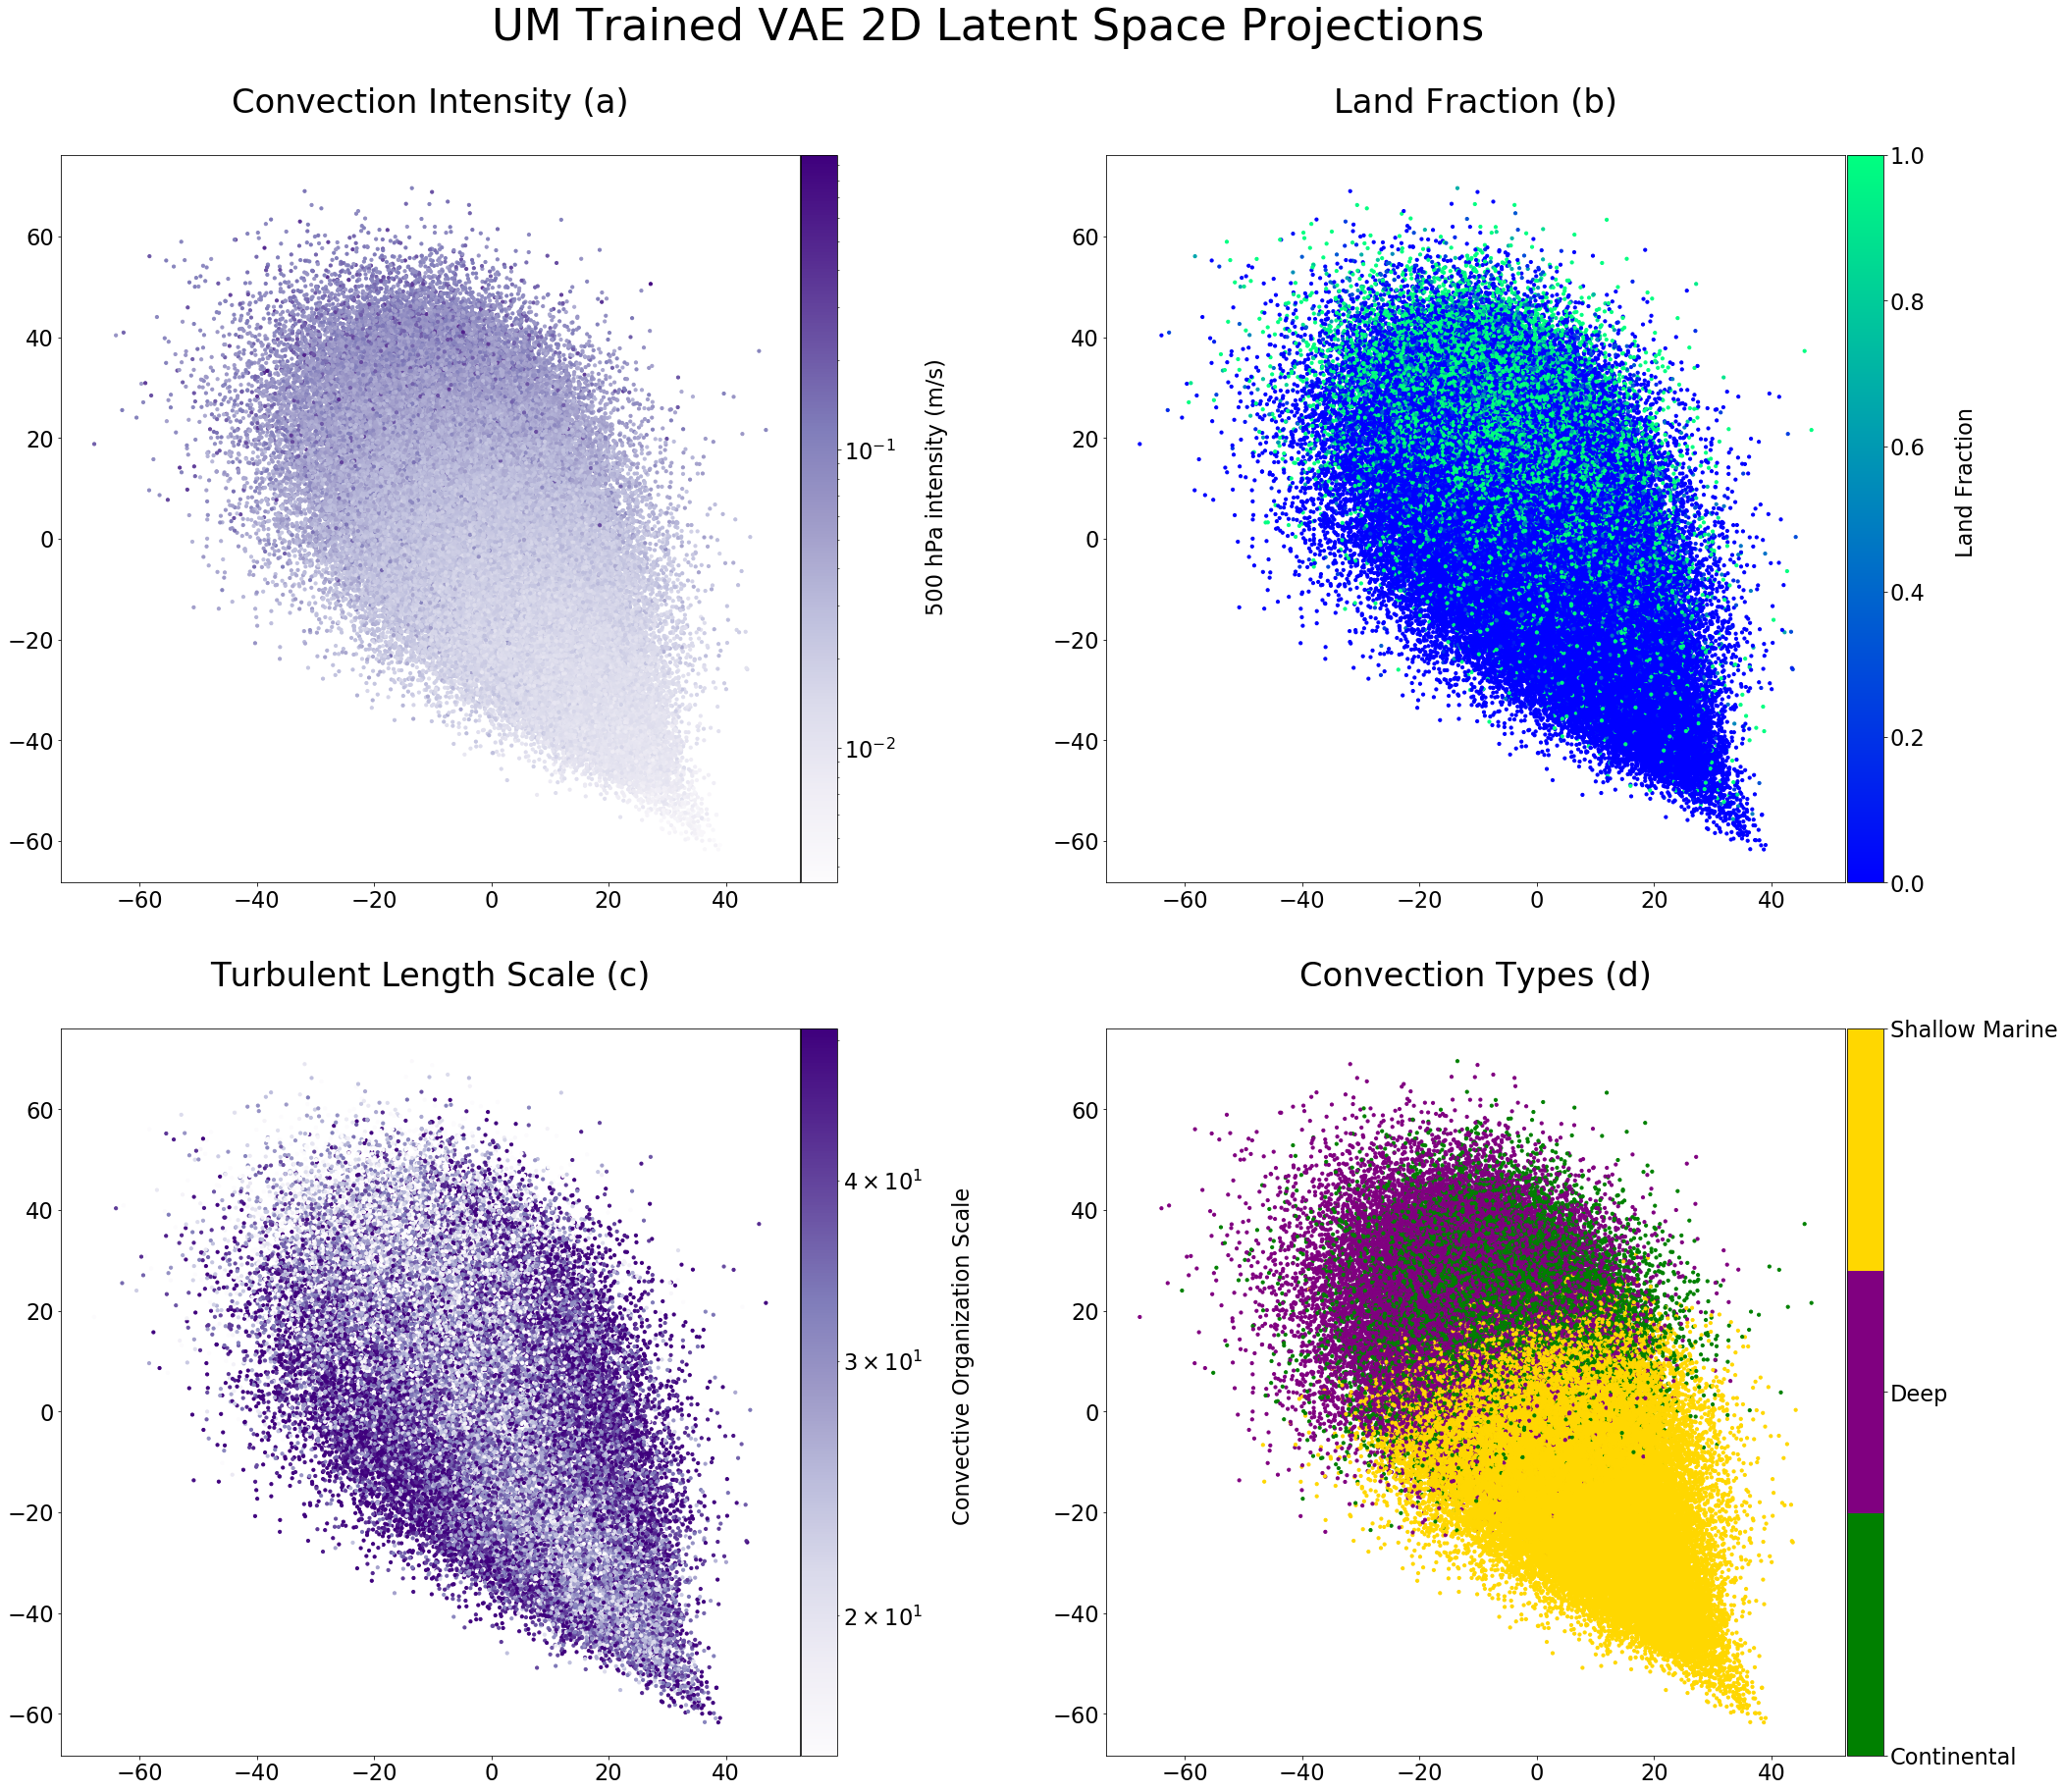

In [15]:


fig, ax = plt.subplots(2,2,figsize=(35,30))
gs=GridSpec(2,2)

vmin = 0.01
vmax = 1

ax1 = fig.add_subplot(gs[0,0])

cp = ax1.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1], c=W_500_w_test_SAM, cmap="Purples", s=10.0, norm=matplotlib.colors.LogNorm(), alpha=1)
ax1.set_title("Convection Intensity (a)", fontsize = fz*1.5, y = 1.05)

cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label='500 hPa intensity (m/s) ', rotation="vertical", labelpad=30, y = 0.55)
cbar.set_alpha(1)
cbar.draw_all()

#ax1.set_xlim(-115,80)
#ax1.set_ylim(-50,85)

ax2 = fig.add_subplot(gs[0,1])
vmin = 0
vmax = 1
cp = ax2.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1], c=ifs_land_frac, cmap="winter", s=10.0, vmin=vmin, vmax=vmax, alpha=1)
ax2.set_title("Land Fraction (b)", fontsize = fz*1.5, y = 1.05)

#ax2.set_xlim(-115,80)
#ax2.set_ylim(-50,85)

cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Land Fraction", rotation="vertical", labelpad=30, y = 0.55)
cbar.set_alpha(1)
cbar.draw_all()

ax3 = fig.add_subplot(gs[1,0])

vmin=2
vmax=256

cp = ax3.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1], c=EQ_1_ww_test_SAM_profile, cmap="Purples", s=10.0, norm=matplotlib.colors.LogNorm(), vmin=16, vmax=51.0, alpha=1)
ax3.set_title("Turbulent Length Scale (c)", fontsize = fz*1.5, y = 1.05)

#ax3.set_xlim(-115,80)
#ax3.set_ylim(-50,85)

cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Convective Organization Scale", rotation="vertical", labelpad=30, y = 0.55)
cbar.set_alpha(1)
cbar.draw_all()

ax4 = fig.add_subplot(gs[1,1])

cmap = matplotlib.colors.ListedColormap(["green","purple","gold"])

cp = ax4.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1],  c=labels_3_SAM, cmap=cmap, s=10.0)
ax4.set_title("Convection Types (d)", fontsize = fz*1.5, y = 1.05)

#ax4.set_xlim(-115,80)
#ax4.set_ylim(-50,85)


cbar = fig.colorbar(cp, pad=0.002, ticks=[-1,0,1,2])
cbar.ax.set_yticklabels(["Nothing","Continental","Deep","Shallow Marine"]) 
#n_clusters=3
#tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
#cbar.set_ticks(tick_locs)

cbar.ax.tick_params(labelsize=fz)
#cbar.set_alpha(1)
#cbar.draw_all()

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])

#plt.subplots_adjust(wspace=0.01)

plt.suptitle("UM Trained VAE 2D Latent Space Projections", fontsize = fz*2.0, y = 0.95)

plt.savefig("../Figures/Figure_S3.png", bbox_inches='tight', pad_inches = 0.1)